In [53]:
from langgraph.graph import StateGraph, START, END
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv
import os
from typing import TypedDict, Annotated, Literal
from pydantic import BaseModel, Field # This is needed for Structured Output from LLM Models.

In [54]:
load_dotenv()

True

In [55]:
model = init_chat_model(
    model="google_genai:gemini-2.5-flash-lite",
    temperature=0.6,
    max_tokens=400,
    timeout=None,
    max_retries=2,
)

In [56]:
prompt = """You are an expert software engineer. What are real usees of Docker, in 300 words?"""
model.invoke(prompt).content

'As an expert software engineer, I see Docker as a transformative tool with a wide array of practical applications that streamline development, deployment, and operations.\n\n**Development Environments:** Docker excels at creating consistent, isolated development environments. Developers can spin up pre-configured containers with specific language versions, databases, and dependencies, eliminating the "it works on my machine" problem. This ensures everyone on the team uses the exact same setup, reducing integration headaches.\n\n**Application Deployment:** Docker containers package applications and their dependencies into portable units. This makes deployment incredibly simple and repeatable across different environments – from a developer\'s laptop to staging servers and production. The immutability of containers means you deploy the exact same artifact every time, leading to greater stability and predictability.\n\n**Microservices Architecture:** Docker is a natural fit for microserv

### We need 3 Different LLM,
#### 1st: Generate Twitter Post
#### 2nd: Evaluation of Generated Post
#### 3rd: Optimize the Twitter

In [57]:
generator_llm = model
evaluator_llm = model
optimizer_llm = model

#### State of Graph

In [58]:
class TweetState(TypedDict):

    topic: str
    tweet: str
    evaluation: Literal["Approved", "Needs_Improvement"]
    feedback: str

    iteration: int
    max_iteration: int

In [59]:
from langchain_core.messages import SystemMessage, HumanMessage

In [60]:
def generate_tweet(state: TweetState):

    # prompt
    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
""")
    ]

    # Send to LLM
    tweet = generator_llm.invoke(messages).content

    return {
        "tweet" : tweet
    }

#### We have to make schema for structured output for Evaluation model, like only "Approved" or "Need Improvement

In [61]:
class evaluationSchema(BaseModel):

    evaluation: Literal['approved', 'needs_improvement'] = Field(description="The evaluation result of the tweet.")
    feedback: str = Field(description="Feedback on the tweet's performance.")

#### Maked structured Evaluation Model

In [62]:
evaluator_llm_structured = evaluator_llm.with_structured_output(evaluationSchema)

In [63]:
def evaluate_tweet(state: TweetState):

    # Prompt
    messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
Evaluate the following tweet:

Tweet: "{state['tweet']}"

Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?  
2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
3. Punchiness – Is it short, sharp, and scroll-stopping?  
4. Virality Potential – Would people retweet or share it?  
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"  
- feedback: One paragraph explaining the strengths and weaknesses 
""")
]

    # Evaluation Criteria => [Approved, Needs_Improvement] so we need a structured output.

    evaluation = evaluator_llm_structured.invoke(messages)

    return {
        'evaluation' : evaluation.evaluation,
        'feedback' : evaluation.feedback
    }

In [ ]:
def optimize_tweet(state: TweetState):

    # Prompt
    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state['feedback']}"

Topic: "{state['topic']}"
Original Tweet:
{state['tweet']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
    ]

    # Send to LLM
    optimized_tweet = optimizer_llm.invoke(messages).content

    iteration = state['iteration'] + 1

    # return optimized tweet
    return {
        "tweet": optimized_tweet,
        "iteration": iteration
    }

In [65]:
def route_evaluation(state: TweetState):

    if state['evaluation'] == "Approved" or state['iteration'] >= state['max_iteration']:
        return "approved"
    return "need_improvements"

In [66]:
graph = StateGraph(TweetState)

graph.add_node("Generate", generate_tweet)
graph.add_node("Evaluate", evaluate_tweet)
graph.add_node("Optimize", optimize_tweet)

graph.add_edge(START, "Generate")
graph.add_edge("Generate", "Evaluate")

graph.add_conditional_edges("Evaluate", route_evaluation, {'approved': END, 'need_improvements': "Optimize"})
graph.add_edge("Optimize", "Evaluate")

workflow = graph.compile()



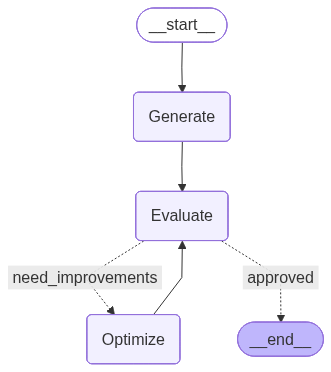

In [67]:
workflow

In [68]:
initial_state = {
    'topic': 'AI in West Bengal Elections',
    'iteration': 1,
    'max_iteration': 5
}

result = workflow.invoke(initial_state)

Optimizing tweet with feedback: The tweet attempts a topical joke about AI and elections, but it falls flat. The humor relies on a predictable trope of bribing algorithms, and the rosogolla reference feels forced rather than genuinely funny. It's not particularly original, and the punchline is weak, lacking the sharpness needed for virality. While it's under the character limit and not a Q&A, the overall execution needs significant improvement to be considered approved.
Optimized tweet: Here are a few options, playing with different angles to make it funnier and more viral:

**Option 1 (Focus on the absurdity):**

> Heard AI is predicting Bengal election results. My prediction? It's gonna say "Mamata Banerjee wins... if you feed the AI enough rosogollas. It's a sweet deal, apparently." 🍬 #BengalElections #AI

**Option 2 (More direct and punchy):**

> West Bengal elections are so advanced, AI's predicting results. Pretty sure it'll just spit out: "Didi wins, but the algorithm demands a 

ChatGoogleGenerativeAIError: Error calling model 'gemini-2.5-flash-lite' (RESOURCE_EXHAUSTED): 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 10, model: gemini-2.5-flash-lite\nPlease retry in 7.240106469s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-2.5-flash-lite'}, 'quotaValue': '10'}]}, {'@type': 'type.googleapis.com/google.rpc.RetryInfo', 'retryDelay': '7s'}]}}